**Group H**

•	Saurabh Laltaprasad Gangwar

•	Brayan Leonardo Gil Guevara

•	Rohit Kumar

•	Marzieh Mohammadi Kokaneh

•	Eduardo Roberto Williams Cascante

**Notebook name:** BDM-3035_02.ipynb

**Description:** This notebook performs the augmentation process

In [1]:
# installin tensorflow, opencv and albumentations libraries
%pip install tensorflow opencv-python albumentations

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# updating tensorflow
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# upgrading albumentations
%pip install --upgrade albumentations

   ---------------------------------------- 0.0/156.8 kB ? eta -:--:--
   ---------------------------------------- 156.8/156.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.7
    Uninstalling albumentations-1.4.7:
      Successfully uninstalled albumentations-1.4.7
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd
import numpy  as np
import os
import cv2
import time
import uuid
import json
import albumentations as alb

from matplotlib import pyplot as plt

# Importing layers and base network
import tensorflow as tf
from tensorflow.keras.models       import load_model, Model
from tensorflow.keras.layers       import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16 

In [40]:
# defining paths
dir_train_img = "data/train/images/"
# dir_train_lab = "data/train/labels/"
# dir_test_img = "data/test/images/"
# dir_test_lab = "data/test/labels/"
# dir_valid_img = "data/valid/images/"
# dir_valid_lab = "data/valid/labels/"
diraug_train_img = "data_aug/train/images/"
diraug_train_lab = "data_aug/train/labels/"
diraug_test_img = "data_aug/test/images/"
diraug_test_lab = "data_aug/test/labels/"
diraug_valid_img = "data_aug/valid/images/"
diraug_valid_lab = "data_aug/valid/labels/"

In [41]:
# defining load_image function

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [42]:
# defining load_labels function

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
         label = json.load(f)
         
    return [label['class']], label['bbox']

In [43]:
# verifying images
images = tf.data.Dataset.list_files(dir_train_img + '*.jpg', shuffle = False)

In [44]:
images.as_numpy_iterator().next()

b'data\\train\\images\\EDU_0001.JPG'

In [45]:
# loading images
images = images.map(load_image)

In [46]:
images.as_numpy_iterator().next()

array([[[ 48,  51,  42],
        [ 43,  46,  37],
        [ 57,  60,  51],
        ...,
        [ 30,  34,  35],
        [ 31,  35,  36],
        [ 32,  36,  37]],

       [[ 47,  50,  41],
        [ 63,  66,  57],
        [ 81,  84,  75],
        ...,
        [ 29,  33,  34],
        [ 30,  34,  35],
        [ 30,  34,  35]],

       [[ 66,  69,  58],
        [ 85,  88,  77],
        [ 94,  97,  86],
        ...,
        [ 30,  34,  35],
        [ 30,  34,  35],
        [ 30,  34,  35]],

       ...,

       [[ 51,  63,  59],
        [113, 125, 121],
        [125, 138, 131],
        ...,
        [225, 123, 119],
        [232, 124, 122],
        [232, 120, 118]],

       [[ 34,  46,  42],
        [ 82,  94,  90],
        [128, 141, 134],
        ...,
        [226, 122, 119],
        [238, 128, 127],
        [234, 122, 120]],

       [[ 30,  42,  38],
        [ 51,  63,  59],
        [120, 133, 126],
        ...,
        [229, 125, 122],
        [239, 129, 128],
        [233, 121, 119]]

In [47]:
# viewing raw images with Matplotlib
image_generator = images.batch(4).as_numpy_iterator()

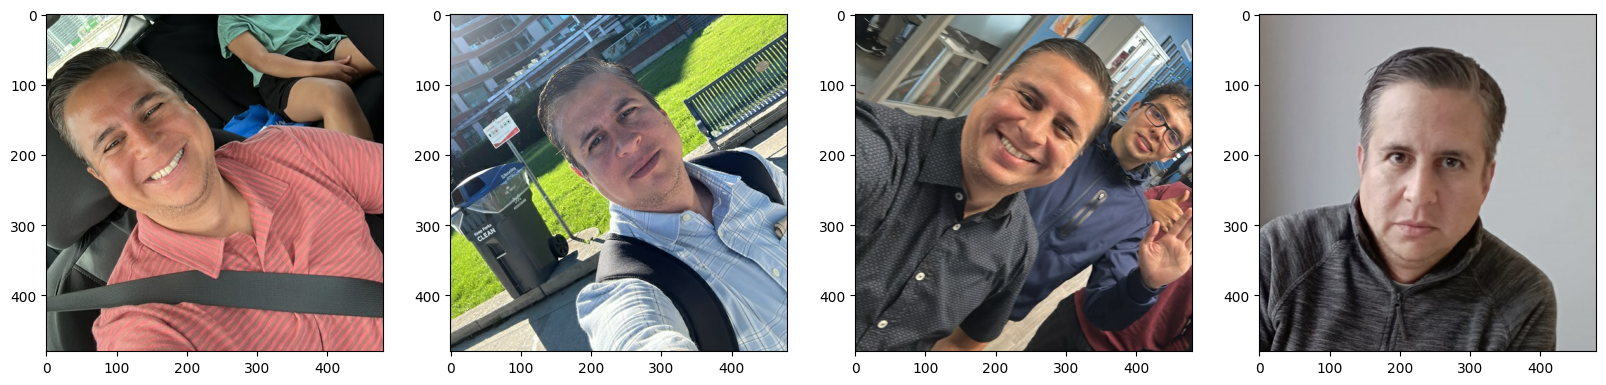

In [48]:
plot_images = image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)

plt.show()

***
**DATA SPLITTING**
***

In this step you have to take (manually) all jpg files from images folder and distribute them as follows:
- TRAIN folder --> 70%
- TEST folder  --> 15%
- VALID folder --> 15%

And after that execute following section (# Move the matching labels)

In [ ]:
# Move the matching labels
for folder in ['train', 'test', 'valid']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
           new_filepath = os.path.join('data', folder, 'labels', filename)
           os.replace(existing_filepath, new_filepath)

**DATA AUGMENTATION**

In [50]:
# setup albumentations transform pipeline

augmentor = alb.Compose([alb.RandomCrop(width=480, height=480),
            alb.HorizontalFlip(p=0.5),
            alb.RandomBrightnessContrast(p=0.2),
            alb.RandomGamma(p=0.2),
            alb.RGBShift(p=0.2),
            alb.VerticalFlip(p=0.5)],
            bbox_params = alb.BboxParams(format='albumentations',
                                         label_fields=['class_labels']))

In [51]:
# load a Test image and annotation with OpenCV and JSON
img = cv2.imread(os.path.join('data', 'train', 'images', 'EDU_0001.jpg'))

with open(os.path.join('data', 'train', 'labels', 'EDU_0001.json'), 'r') as f:
     label = json.load(f)

label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'Eduardo',
   'points': [[2.5, 48.33333333333333], [247.5, 300.0]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\img\\EDU_0001.JPG',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAeADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3e

In [52]:
label['shapes'][0]['points']

[[2.5, 48.33333333333333], [247.5, 300.0]]

In [53]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[2.5, 48.33333333333333, 247.5, 300.0]

In [54]:
coords = list(np.divide(coords, [480,480,480,480]))
coords

[0.005208333333333333, 0.10069444444444443, 0.515625, 0.625]

In [55]:
# Applying augmentations just for one image to view results
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Eduardo'])
augmented

{'image': array([[[ 42,  50,  49],
         [ 38,  46,  45],
         [ 52,  61,  58],
         ...,
         [ 36,  35,  31],
         [ 37,  36,  32],
         [ 37,  36,  32]],
 
        [[ 42,  50,  49],
         [ 58,  66,  65],
         [ 76,  85,  82],
         ...,
         [ 35,  34,  30],
         [ 35,  34,  30],
         [ 36,  35,  31]],
 
        [[ 61,  70,  67],
         [ 80,  89,  86],
         [ 89,  98,  95],
         ...,
         [ 35,  34,  30],
         [ 35,  34,  30],
         [ 35,  34,  30]],
 
        ...,
 
        [[ 60,  64,  53],
         [122, 126, 115],
         [134, 138, 127],
         ...,
         [121, 123, 225],
         [122, 124, 232],
         [119, 120, 232]],
 
        [[ 42,  46,  34],
         [ 91,  95,  83],
         [138, 142, 130],
         ...,
         [121, 122, 226],
         [126, 127, 237],
         [120, 122, 234]],
 
        [[ 38,  42,  30],
         [ 60,  64,  52],
         [130, 134, 122],
         ...,
         [122, 125,

In [56]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [57]:
augmented['image']

array([[[ 42,  50,  49],
        [ 38,  46,  45],
        [ 52,  61,  58],
        ...,
        [ 36,  35,  31],
        [ 37,  36,  32],
        [ 37,  36,  32]],

       [[ 42,  50,  49],
        [ 58,  66,  65],
        [ 76,  85,  82],
        ...,
        [ 35,  34,  30],
        [ 35,  34,  30],
        [ 36,  35,  31]],

       [[ 61,  70,  67],
        [ 80,  89,  86],
        [ 89,  98,  95],
        ...,
        [ 35,  34,  30],
        [ 35,  34,  30],
        [ 35,  34,  30]],

       ...,

       [[ 60,  64,  53],
        [122, 126, 115],
        [134, 138, 127],
        ...,
        [121, 123, 225],
        [122, 124, 232],
        [119, 120, 232]],

       [[ 42,  46,  34],
        [ 91,  95,  83],
        [138, 142, 130],
        ...,
        [121, 122, 226],
        [126, 127, 237],
        [120, 122, 234]],

       [[ 38,  42,  30],
        [ 60,  64,  52],
        [130, 134, 122],
        ...,
        [122, 125, 230],
        [128, 129, 239],
        [118, 120, 232]]

In [58]:
augmented['bboxes']

[(0.005208333333333333, 0.10069444444444443, 0.515625, 0.625)]

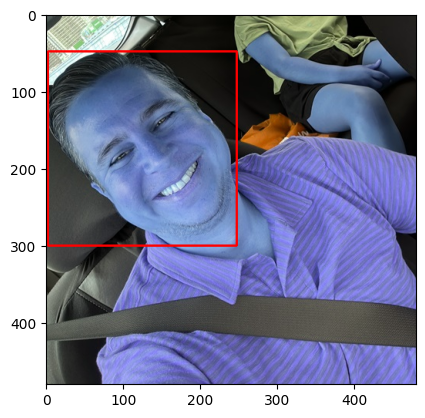

In [59]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [480,480]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [480,480]).astype(int)),
              (255,0,0), 2)

plt.imshow(augmented['image'])

In [60]:
# Build and run augmentation pipeline
# Applying augmentation for all pictures (jpg files)

for partition in ['train', 'test', 'valid']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')

        if os.path.exists(label_path):
           with open(label_path, 'r') as f:
                label = json.load(f)

           coords[0] = label['shapes'][0]['points'][0][0]
           coords[1] = label['shapes'][0]['points'][0][1]
           coords[2] = label['shapes'][0]['points'][1][0]
           coords[3] = label['shapes'][0]['points'][1][1]
           coords = list(np.divide(coords, [480,480,480,480]))
           
        try:
           for x in range(60):
               classNumber = 0
               augmented = augmentor(image = img, bboxes = [coords], class_labels = [label['shapes'][0]['label']])
               cv2.imwrite(os.path.join('data_aug', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
               annotation = {}
               annotation['image'] = image
               if os.path.exists(label_path):
                  if len(augmented['bboxes']) == 0:
                     annotation['bbox']  = [0,0,0,0]
                     annotation['class'] = classNumber
                     annotation['label'] = ""
                  else:                   
                     annotation['bbox'] = augmented['bboxes'][0]
                     annotation['class'] = 1
                     annotation['label'] = label['shapes'][0]['label']
               else:
                  annotation['bbox']  = [0,0,0,0]
                  annotation['class'] = classNumber
                  annotation['label'] = ""
                  
               with open(os.path.join('data_aug', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.5098684210526316, 0.8607456140350878, 0.007675438596491327, 0.10745614035087724, 'Leo'].
x_max is less than or equal to x_min for bbox [0.4791666666666667, 0.743421052631579, 0.0, 0.05827776454711433, 'Leo'].
x_max is less than or equal to x_min for bbox [0.32017543859649134, 0.4736842105263159, 0.010964912280701828, 0.038377192982456204, 'Leo'].
x_max is less than or equal to x_min for bbox [0.3508771929824562, 0.6425438596491229, 0.0, 0.1758006777067278, 'Leo'].
x_max is less than or equal to x_min for bbox [0.47149122807017546, 0.7752192982456141, 0.023026315789473745, 0.09539473684210531, 'Leo'].
x_max is less than or equal to x_min for bbox [0.34649122807017546, 0.7565789473684211, 0.013157894736842183, 0.3344298245614036, 'Leo'].


In [61]:
# load train augmented images to tensorflow dataset
train_images = tf.data.Dataset.list_files(diraug_train_img + '*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [62]:
# load test augmented images to tensorflow dataset
test_images = tf.data.Dataset.list_files(diraug_test_img + '*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [63]:
# load valid augmented images to tensorflow dataset
val_images = tf.data.Dataset.list_files(diraug_valid_img + '*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [64]:
# load train labels to Tensorflow Dataset
train_labels = tf.data.Dataset.list_files(diraug_train_lab + '*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [65]:
# load test labels to Tensorflow Dataset
test_labels = tf.data.Dataset.list_files(diraug_test_lab + '*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [66]:
# load valid labels to Tensorflow Dataset
val_labels = tf.data.Dataset.list_files(diraug_valid_lab + '*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [67]:
# check partition lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8220, 8220, 1680, 1680, 1740, 1740)

In [68]:
# conbining train labels and images samples
# creating final train dataset (images/labels)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [69]:
# testing final train dataset
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.3154 , 0.2014 , 0.7183 , 0.5786 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2634 , 0.2534 , 0.7056 , 0.9004 ],
        [0.1672 , 0.4062 , 0.6    , 0.9097 ],
        [0.3826 , 0.2559 , 0.938  , 0.766  ],
        [0.2783 , 0.288  , 0.738  , 0.8193 ],
        [0.2644 , 0.11456, 0.7075 , 0.6655 ]], dtype=float16))

In [70]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [71]:
# 7.3 view images and annotations
data_samples = train.as_numpy_iterator()

In [83]:
res = data_samples.next()

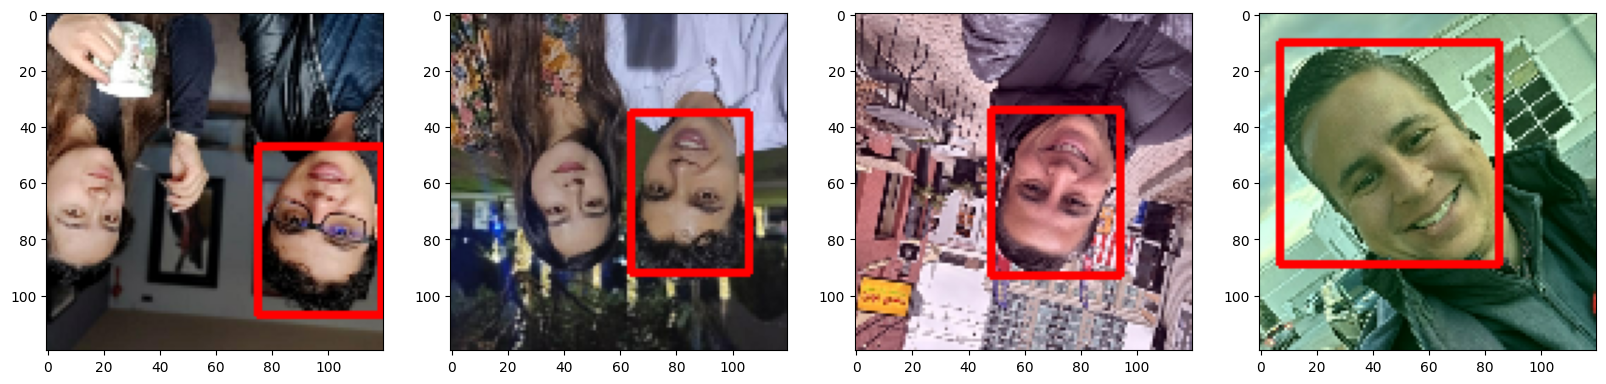

In [84]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coord = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coord[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coord[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
     
    ax[idx].imshow(sample_image)